# Automated wear analysis of a gear

This exercise explores the application of computational techniques to analyse wear on gear teeth using image processing methods. Gears are critical components in mechanical systems, and wear can significantly affect performance, leading to inefficiencies, vibrations, and potential failure. Traditional inspection methods are time-consuming and prone to human error. This study formalises and implements an automated approach to detecting worn teeth by analysing the gear’s geometry through image processing. By extracting and comparing key features of the gear’s contour, this method enhances accuracy, reduces manual effort, and improves maintenance efficiency.

## Problem formulation

The detection of worn teeth on a gear consists of a sequence of image processing steps that analyse the geometry of the gear and its teeth. The following outlines the problem formulation and the steps necessary to achieve the goal.

### Step 1: image preprocessing

The input image $I(x, y)$ is processed to reduce noise and prepare it for further analysis. First, it is converted to a greyscale image $G(x, y)$ then, noise reduction is performed by applying a Gaussian filter $\mathcal{G}(u, v; \sigma)$, defined as

$$
\mathcal{G}(u, v; \sigma) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{u^2 + v^2}{2\sigma^2}\right)
$$

where $\sigma$ is the standard deviation of the Gaussian kernel. The smoothed image $G'(x, y)$ is obtained through discrete convolution of the greyscale image with the Gaussian filter:

$$
G'(x, y) = \sum_{u=-k}^k \sum_{v=-k}^k G(x-u, y-v) \cdot \mathcal{G}(u, v; \sigma)
$$

### Step 2: thresholding

The purpose of thresholding is to segment the gear from the background. Adaptive thresholding is employed, which computes a threshold value $T(x, y)$ based on local intensity variations. The binary image $B(x, y)$ is then defined as:

$$
B(x, y) =
\begin{cases}
1 & \text{if } G'(x, y) \leq T(x, y), \\
0 & \text{otherwise}.
\end{cases}
$$

### Step 3: contour detection

To analyse the gear's geometry, its outer contour is identified. The contours are defined as sets of connected pixels forming boundaries between regions. Among all detected contours $\{C_i\}$, the gear's contour $C_{\text{gear}}$ is selected as the one with the largest area:

$$
C_{\text{gear}} = \arg\max_{C_i} \text{Area}(C_i).
$$

### Step 4: centroid calculation

The centroid $(x_c, y_c)$ of the detected gear contour $C_{\text{gear}}$ is computed using image moments. The spatial moments $M_{pq}$ are defined as:

$$
M_{pq} = \sum_{(x, y) \in C_{\text{gear}}} x^p y^q.
$$

The centroid coordinates are calculated as:

$$
x_c = \frac{M_{10}}{M_{00}}, \quad y_c = \frac{M_{01}}{M_{00}},
$$

where $M_{00}$ is the zeroth moment representing the total area of the contour.

### Step 5: key point detection

Key points along the gear's teeth are identified by analysing the distances of contour points from the centroid. The radial distance $d_i$ for a point $p_i = (x_i,y_i)$ is calculated as:

$$
d_i = \sqrt{(x_i - x_c)^2 + (y_i - y_c)^2}.
$$

Points with distances above a certain threshold are considered to belong to the teeth.

### Step 6: worn teeth detection

Worn teeth are identified by detecting key points that are anomalously close to the centroid. A distance threshold $d_{\text{worn}}$ is defined, and a tooth is classified as worn if its radial distance $d_i$ satisfies:

$$
d_i < d_{\text{worn}}.
$$

The number of worn teeth is then computed, providing a quantitative assessment of the gear's condition.


## Implementation

The following implementation demonstrates how the mathematical principles outlined in the problem formulation section are translated into practical code. Each step corresponds directly to the mathematical operations defined earlier, using image processing techniques to automate the detection of worn teeth on a gear.


### 1. Image preprocessing

The first step involves loading the image, converting it to greyscale, and then applying a Gaussian filter for noise reduction. This corresponds to the formulas for greyscale conversion and discrete convolution with a Gaussian kernel.


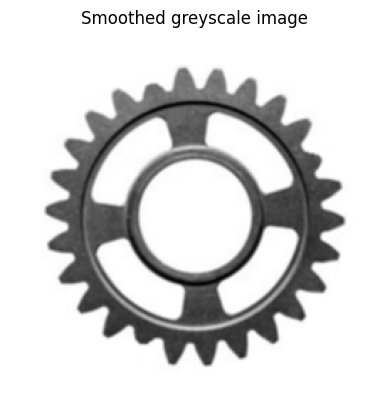

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Function to display an image
def display_image(title, image, cmap="gray"):
    """
    Display an image with a given title and colormap.

    Parameters
    ----------
    title : str
        Title of the image.
    image : numpy.ndarray
        Image to display.
    cmap : str, optional
        Colormap to use for displaying the image. Default is "gray".
    """
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()


# Load the input image
image_path = "data/worn_gear.jpg"
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at: {image_path}")

# Convert to greyscale
greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian smoothing
sigma = 1  # Standard deviation for Gaussian kernel
kernel_size = int(2 * np.ceil(sigma) + 1)  # Kernel size
smoothed_image = cv2.GaussianBlur(greyscale_image, (kernel_size, kernel_size), sigma)

display_image("Smoothed greyscale image", smoothed_image)

### 2. Thresholding

Next, global thresholding is applied to segment the gear from the background. This step corresponds to the binary segmentation formula using a globally computed threshold.


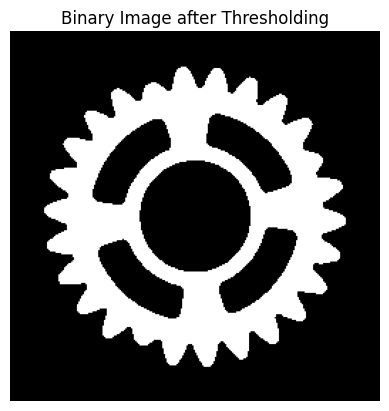

In [2]:
# Application of adaptive thresholding
_, binary_image = cv2.threshold(smoothed_image, 224, 255, cv2.THRESH_BINARY_INV)

display_image("Binary Image after Thresholding", binary_image)

### 3. Contour detection

Contours of the gear are detected, and the largest contour is selected as the gear's outer boundary. This step corresponds to the identification of the contour with the largest area.


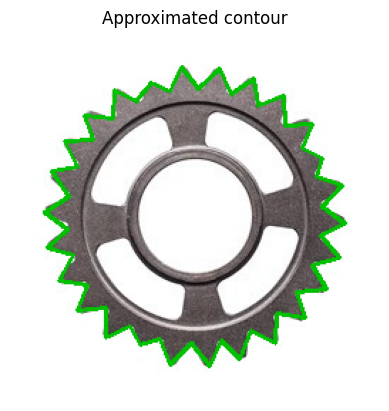

In [3]:
# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour
gear_contour = max(contours, key=cv2.contourArea)

# Approximating the contour with a polygon to identify key points (vertices of the teeth)
contour_image = cv2.arcLength(gear_contour, True)
approximated_contour = cv2.approxPolyDP(gear_contour, 0.005 * contour_image, True)

# Displaying the approximated contour on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, [approximated_contour], -1, (0, 192, 0), 2)

# Display the image with the approximated contour
display_image("Approximated contour", contour_image)

### 4. Centroid calculation

The centroid of the gear's contour is computed using image moments. This corresponds to the formulas for spatial moments and centroid coordinates.


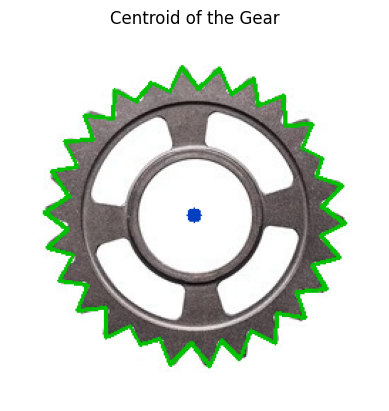

In [4]:
# Calculate the moments of the contour
moments = cv2.moments(gear_contour)

# Compute the centroid coordinates
centroid_x = int(moments["m10"] / moments["m00"])
centroid_y = int(moments["m01"] / moments["m00"])

# Mark the centroid
cv2.circle(contour_image, (centroid_x, centroid_y), 5, (0, 64, 192), -1)
display_image("Centroid of the Gear", contour_image)

### 5. Key point detection

Key points along the gear’s teeth are identified based on their distance from the centroid. This corresponds to the formula for radial distance from the centroid.


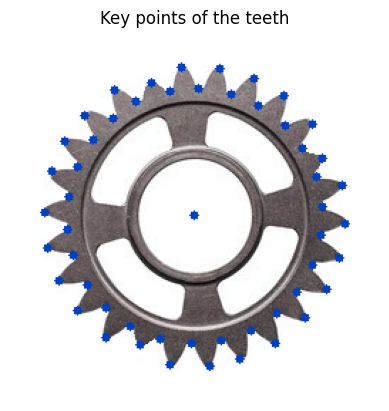

In [5]:
# Segment the teeth using the key points from the approximated contour
key_points = []
key_points_image = image.copy()

# Display the detected key points
for point in approximated_contour:
    cv2.circle(key_points_image, tuple(point[0]), 3, (0, 64, 192), -1)

# Display the centroid
cv2.circle(key_points_image, (centroid_x, centroid_y), 3, (0, 64, 192), -1)

display_image("Key points of the teeth", key_points_image)

### 6. Worn teeth detection

Worn teeth are identified as key points with radial distances below a predefined threshold.


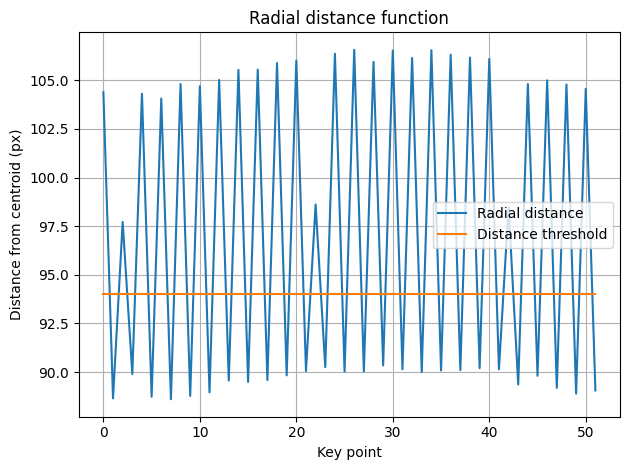

In [6]:
# Calculation of the distance of the key points from the centroid
distances = []
for point in approximated_contour:
    x, y = point[0]
    distance = np.sqrt((x - centroid_x) ** 2 + (y - centroid_y) ** 2)
    distances.append(distance)

# Definition of the distance threshold (e.g., the 50th percentile of the distances)
threshold_distance = np.percentile(distances, 50)

# Plot the radial distances
plt.plot(distances, label="Radial distance")
plt.plot(
    np.arange(len(distances)),
    threshold_distance * np.ones_like(distances),
    label="Distance threshold",
)

# Set titles and labels
plt.title("Radial distance function")
plt.xlabel("Key point")
plt.ylabel("Distance from centroid (px)")
plt.legend()
plt.grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Points that are closer to the centroid than the threshold value (calculated) are removed. The number of these points will correspond to the number of teeth present in the gear.


Number of detected teeth: 26.


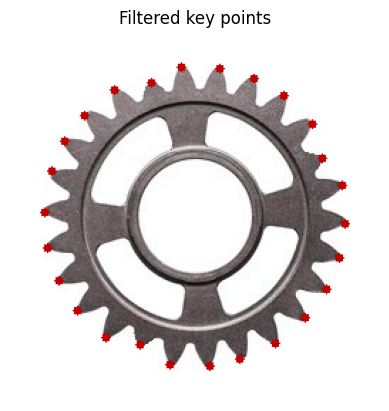

In [7]:
# Removal of points that are closer to the centroid
filtered_points = []
for i, point in enumerate(approximated_contour):
    if distances[i] > threshold_distance:
        filtered_points.append(point)

# Display the filtered key points
key_points_image = image.copy()
for point in filtered_points:
    cv2.circle(key_points_image, tuple(point[0]), 3, (192, 0, 0), -1)

print(f"Number of detected teeth: {len(filtered_points)}.")

# Show the image with the filtered key points
display_image("Filtered key points", key_points_image)


The radial distance of the key points from the centroid of the gear is recalculated. Points representing the vertices of teeth that have a distance from the centroid lower than a predefined threshold value indicate that the tooth may be affected by wear.


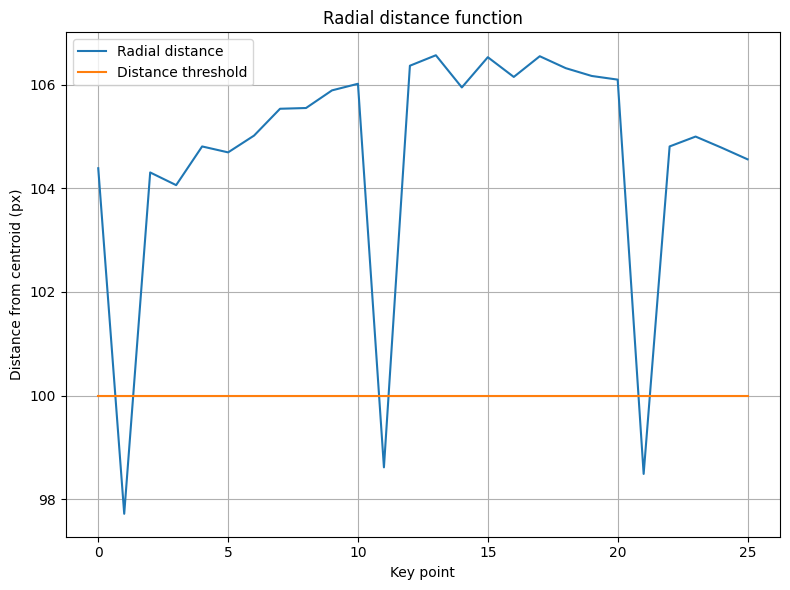

In [8]:
# Calculation of the distance of the key points from the centroid
distances = []
for point in filtered_points:
    x, y = point[0]
    distance = np.sqrt((x - centroid_x) ** 2 + (y - centroid_y) ** 2)
    distances.append(distance)

# Definition of the distance threshold (e.g., the 50th percentile of the distances)
distance_threshold = 100

worn_teeth = []
for i, point in enumerate(filtered_points):
    if distances[i] < distance_threshold:
        worn_teeth.append(point)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot radial distance
plt.plot(distances, label="Radial distance")
plt.plot(
    np.arange(len(distances)),
    distance_threshold * np.ones_like(distances),
    label="Distance threshold",
)

# Set titles and labels
plt.title("Radial distance function")
plt.xlabel("Key point")
plt.ylabel("Distance from centroid (px)")
plt.legend()
plt.grid()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Visualisation of potentially worn teeth on the gear.


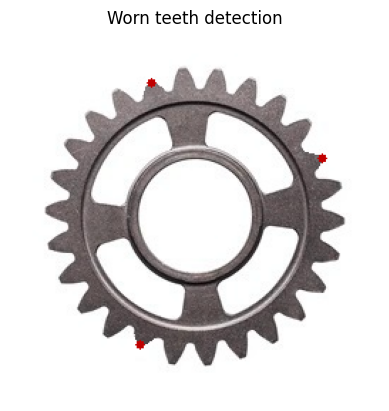

Total number of teeth detected: 26
Number of worn teeth: 3
Percentage of worn teeth: 11.54%


In [9]:
# Display of points that are closer to the centroid than the threshold
worn_teeth_image = image.copy()
for tooth in worn_teeth:
    cv2.circle(worn_teeth_image, tuple(tooth[0]), 3, (192, 0, 0), -1)

display_image("Worn teeth detection", worn_teeth_image)

# Calculate statistics
total_teeth = len(filtered_points)
num_worn_teeth = len(worn_teeth)
percentage_worn_teeth = (num_worn_teeth / total_teeth) * 100 if total_teeth > 0 else 0

# Display the statistics
print(f"Total number of teeth detected: {total_teeth}")
print(f"Number of worn teeth: {num_worn_teeth}")
print(f"Percentage of worn teeth: {percentage_worn_teeth:.2f}%")